> In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.

These two major transfer learning scenarios look as follows:

- Finetuning the ConvNet: Instead of random initialization, we initialize the network with a pretrained network, like the one that is trained on imagenet 1000 dataset. Rest of the training looks as usual.

- ConvNet as fixed feature extractor: Here, we will freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained.

In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

# Load Data

We will use torchvision and torch.utils.data packages for loading the data.

The problem we’re going to solve today is to train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.

In [2]:
import os

if not os.path.exists("data"):
  os.makedirs("data")

file_path = "data/hymenoptera_data.zip"
if not os.path.exists(file_path):
  os.system("curl -o %s %s" % (file_path, "https://download.pytorch.org/tutorial/hymenoptera_data.zip"))

if not os.path.exists("data/hymenoptera_data") and os.path.exists(file_path):
  os.system("unzip %s -d data" % file_path)

del file_path

# Why Keep These Values for Transfer Learning?

Even if your dataset is different from ImageNet:

Pretrained models have learned features tuned to ImageNet’s normalization.

Changing mean/std would require retraining the model from scratch (defeating the purpose of transfer learning).

Exception: If your dataset’s distribution is wildly different (e.g., medical images), you might need domain-specific normalization.

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
  'train': transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    # channel-wise mean and standard deviation computed from the ImageNet dataset.
    # Many models are pre-trained on ImageNet, so using these normalization values ensures
    # that the input images have a similar distribution to the data the models saw during
    # training.
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ]),
  'val': transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# We want to be able to train our model on an `accelerator <https://pytorch.org/docs/stable/torch.html#accelerators>`__
# such as CUDA, MPS, MTIA, or XPU. If the current accelerator is available, we will use it. Otherwise, we use the CPU.

device = (torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else 
          "cpu")
print(f"Using {device} device")

Using cuda device


# Visualize a few images

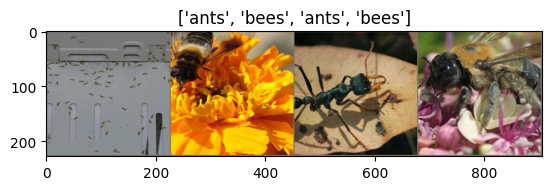

In [4]:
def imshow(inp: torch.Tensor, title=None):
  """Display image for Tensor."""
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean # unnormalize, normalized_value = (original_value - mean) / std
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Training the model

In [ ]:
def train_model(model: nn.Module, criterion: nn.Module, optimizer: torch.optim.Optimizer, 
                scheduler, num_epochs=25):
  since = time.time()

  # Create a temporary directory to save training checkpoints
  with TemporaryDirectory() as tempdir:
    best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

    torch.save(model.state_dict(), best_model_params_path)
    best_acc = 0.0

    for epoch in range(num_epochs):
      print(f'Epoch {epoch}/{num_epochs - 1}')
      print('-' * 10)

      # Each epoch has a training and validation phase
      for phase in ['train', 'val']:
        if phase == 'train':
          model.train()  # Set model to training mode
        else:
          model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in dataloaders[phase]:
          inputs = inputs.to(device)
          labels = labels.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward
          # track history if only in train
          with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1) # preds=indices of the maximum value of the tensor
            loss = criterion(outputs, labels)

            # backward + optimize only if in training phase
            if phase == 'train':
              loss.backward()
              optimizer.step()

          # statistics
          # when computing the loss over an entire epoch,
          # we want to get a total sum loss tht accounts for different batch sizes.
          # by default, most loss functions (like CrossEntropyLoss)
          # return the average lossp er sample in the batch.
          # Multiplying by inputs.size(0) (i.e., the batch size) gives you the
          # total loss for that batch. Later, dividing by the number of samples
          # in the dataset yields the average lossp er sample across the entire epoch.
          # This approach ensures that the loss accounts for varying batch sizes.
          running_loss += loss.item() * inputs.size(0)
          running_corrects += torch.sum(preds == labels.data)
        if phase == 'train':
          scheduler.step()

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # deep copy the model
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            torch.save(model.state_dict(), best_model_params_path)

      print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(torch.load(best_model_params_path, weights_only=True))

  return model

# Visualizing the model predictions

In [12]:
def visualize_model(model: nn.Module, num_images=6):
  was_training = model.training
  model.eval()
  images_so_far = 0
  fig = plt.figure()

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['val']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.size()[0]):
        images_so_far += 1
        ax = plt.subplot(num_images//2, 2, images_so_far)
        ax.axis('off')
        ax.set_title(f'predicted: {class_names[preds[j]]}, actual: {class_names[labels[j]]}')
        imshow(inputs.cpu().data[j])

        if images_so_far == num_images:
          model.train(mode=was_training)
          return
    model.train(mode=was_training)

# Finetuning the ConvNet

In [7]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100.0%


# Train and evaluate

In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5789 Acc: 0.7336
val Loss: 0.4232 Acc: 0.8562

Epoch 1/24
----------
train Loss: 0.5606 Acc: 0.7951
val Loss: 0.6852 Acc: 0.7386

Epoch 2/24
----------
train Loss: 0.7586 Acc: 0.7377
val Loss: 0.2589 Acc: 0.9020

Epoch 3/24
----------
train Loss: 0.5132 Acc: 0.7992
val Loss: 0.4244 Acc: 0.8627

Epoch 4/24
----------
train Loss: 0.4561 Acc: 0.8279
val Loss: 0.9042 Acc: 0.7320

Epoch 5/24
----------
train Loss: 0.4356 Acc: 0.8074
val Loss: 0.2838 Acc: 0.8954

Epoch 6/24
----------
train Loss: 0.6566 Acc: 0.7582
val Loss: 0.3563 Acc: 0.9085

Epoch 7/24
----------
train Loss: 0.4042 Acc: 0.8074
val Loss: 0.3053 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.3100 Acc: 0.8689
val Loss: 0.2772 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.5126 Acc: 0.8074
val Loss: 0.3364 Acc: 0.9150

Epoch 10/24
----------
train Loss: 0.3371 Acc: 0.8607
val Loss: 0.2963 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.3644 Acc: 0.8279
val Loss: 0.3396 Acc: 0.9085

Ep

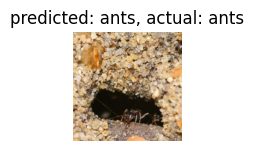

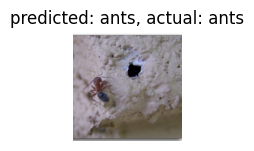

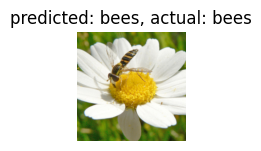

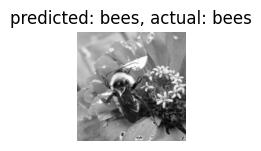

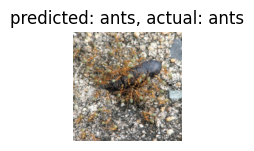

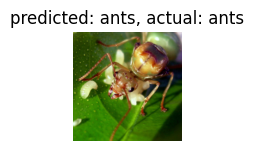

In [14]:
visualize_model(model_ft)

# ConvNet as fixed feature extractor

Here, we need to freeze all the network except the final layer. We need to set `requires_grad = False` to freeze the parameters so that the gradients are not computed in `backward()`.

In [ ]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
  param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

## Train and evaluate

On CPU this will take about half the time compared to previous scenario. This is expected as gradients don’t need to be computed for most of the network. However, forward does need to be computed.

In [16]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5466 Acc: 0.7295
val Loss: 0.2164 Acc: 0.9216

Epoch 1/24
----------
train Loss: 0.4580 Acc: 0.8074
val Loss: 0.2052 Acc: 0.9216

Epoch 2/24
----------
train Loss: 0.4215 Acc: 0.7951
val Loss: 0.1926 Acc: 0.9412

Epoch 3/24
----------
train Loss: 0.5051 Acc: 0.7664
val Loss: 0.4871 Acc: 0.8301

Epoch 4/24
----------
train Loss: 0.5232 Acc: 0.8238
val Loss: 0.2897 Acc: 0.8758

Epoch 5/24
----------
train Loss: 0.4940 Acc: 0.7992
val Loss: 0.2091 Acc: 0.9346

Epoch 6/24
----------
train Loss: 0.3927 Acc: 0.8238
val Loss: 0.3080 Acc: 0.8693

Epoch 7/24
----------
train Loss: 0.3678 Acc: 0.8074
val Loss: 0.1761 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.3962 Acc: 0.8156
val Loss: 0.1729 Acc: 0.9542

Epoch 9/24
----------
train Loss: 0.3621 Acc: 0.8443
val Loss: 0.1874 Acc: 0.9542

Epoch 10/24
----------
train Loss: 0.3139 Acc: 0.8607
val Loss: 0.2047 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.2950 Acc: 0.8811
val Loss: 0.1641 Acc: 0.9608

Ep

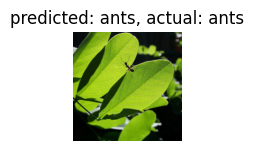

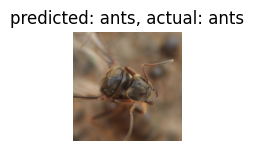

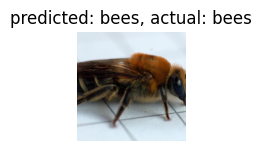

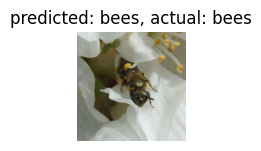

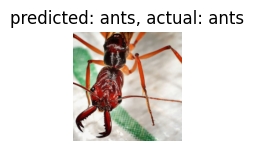

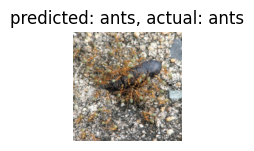

In [17]:
visualize_model(model_conv)

plt.ioff()
plt.show()

# Inference on custom images

Use the trained model to make predictions on custom images and visualize the predicted class labels along with the images.

In [18]:
def visualize_model_predictions(model: nn.Module, img_path: str):
  was_training = model.training
  model.eval()

  img = Image.open(img_path)
  img = data_transforms['val'](img)
  img = img.unsqueeze(0)
  img = img.to(device)

  with torch.no_grad():
    outputs = model(img)
    _, preds = torch.max(outputs, 1)

    ax = plt.subplot(2,2,1)
    ax.axis('off')
    ax.set_title(f'Predicted: {class_names[preds[0]]}')
    imshow(img.cpu().data[0])

    model.train(mode=was_training)

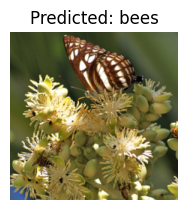

In [19]:
visualize_model_predictions(
    model_conv,
    img_path='data/hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
)

plt.ioff()
plt.show()